In [30]:
#Emircan Ağaç 190401038

In [31]:
import pandas as pd
import torch.nn as nn
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score , precision_score , recall_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # Imported to check if colab is using gpu

start = time.time()

In [32]:
# Define function to train the model
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs=500, early_stop=None, epoch_display=10):
    best_val_loss = np.inf
    patience = 0
    for epoch in range(num_epochs):
        # Train for one epoch
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch)
                val_loss += criterion(y_pred, y_batch.unsqueeze(1)).item()
            val_loss /= len(val_loader)
        
        #Add the training and validation losses to an array.
        list_train_loss.append(train_loss)
        list_val_loss.append(val_loss)

        # Early stopping if validation loss does not improve for early_stop consecutive epochs
        if early_stop is not None and val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        elif early_stop is not None:
            patience += 1
            if patience == early_stop:
                print(f"Stopped training after {epoch} epochs. Best validation loss: {best_val_loss:.4f}")
                break

        # Print loss for every (Default=10) epochs
        if epoch % epoch_display == 0:
              print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [33]:
# Load the data
train_df = pd.read_csv("/content/cure_the_princess_train.csv")
val_df = pd.read_csv("/content/cure_the_princess_validation.csv")
test_df = pd.read_csv("/content/cure_the_princess_test.csv")

# Split into features and target
x_train = train_df.drop('Cured', axis=1).values
y_train = train_df['Cured'].values
x_val = val_df.drop('Cured', axis=1).values
y_val = val_df['Cured'].values
x_test = test_df.drop('Cured', axis=1).values
y_test = test_df['Cured'].values

In [34]:
# Convert to tensors and create datasets and dataloaders
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
# Define the model architecture
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 13 features input dimension to 100 neurons in the first hidden layer
        self.fc1 = nn.Linear(13, 100)
        # 100 neurons in the first hidden layer to 50 neurons in the second hidden layer
        self.fc2 = nn.Linear(100, 50)
        # 50 neurons in the second hidden layer to 1 neuron in the output layer
        self.fc3 = nn.Linear(50, 1)
        # ReLU activation function for hidden layers
        self.relu = nn.ReLU()
        # Sigmoid activation function for output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the first hidden layer followed by ReLU activation
        x = self.relu(self.fc1(x))
        # Forward pass through the second hidden layer followed by ReLU activation
        x = self.relu(self.fc2(x))
        # Forward pass through the output layer followed by Sigmoid activation
        x = self.sigmoid(self.fc3(x))
        return x

In [36]:
torch.manual_seed(190401038)  # Set the seed value to school student number

# Initialize the model and optimizer
model = MLP(input_dim=x_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

list_train_loss = []  
list_val_loss = []  

# Train the model
train(model, optimizer, criterion, train_loader, val_loader, num_epochs=500,early_stop=20)

Epoch 0, Train Loss: 0.6883, Validation Loss: 0.6287
Epoch 10, Train Loss: 0.3704, Validation Loss: 0.3293
Epoch 20, Train Loss: 0.2842, Validation Loss: 0.2378
Epoch 30, Train Loss: 0.2499, Validation Loss: 0.2229
Epoch 40, Train Loss: 0.2206, Validation Loss: 0.1820
Epoch 50, Train Loss: 0.2012, Validation Loss: 0.1703
Epoch 60, Train Loss: 0.1845, Validation Loss: 0.1662
Epoch 70, Train Loss: 0.1679, Validation Loss: 0.1656
Epoch 80, Train Loss: 0.1549, Validation Loss: 0.1461
Epoch 90, Train Loss: 0.1436, Validation Loss: 0.1615
Epoch 100, Train Loss: 0.1370, Validation Loss: 0.1758
Epoch 110, Train Loss: 0.1270, Validation Loss: 0.1399
Epoch 120, Train Loss: 0.1204, Validation Loss: 0.1345
Epoch 130, Train Loss: 0.1137, Validation Loss: 0.1341
Epoch 140, Train Loss: 0.1082, Validation Loss: 0.1324
Epoch 150, Train Loss: 0.1049, Validation Loss: 0.1300
Epoch 160, Train Loss: 0.0967, Validation Loss: 0.1291
Epoch 170, Train Loss: 0.0941, Validation Loss: 0.1320
Epoch 180, Train Loss

In [37]:
# Evaluate on test set
model.eval()
y_pred = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred_batch = model(x_batch)
        y_pred_batch = (y_pred_batch >= 0.5).float()
        y_pred.append(y_pred_batch)
y_pred = torch.cat(y_pred, dim=0).numpy()

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}, Test F1 Score: {f1:.4f}, Test Precision:{precision:.4f}, Test Recall:{recall:.4f}")

Test Accuracy: 0.9482, Test F1 Score: 0.9474, Test Precision:0.9677, Test Recall:0.9278


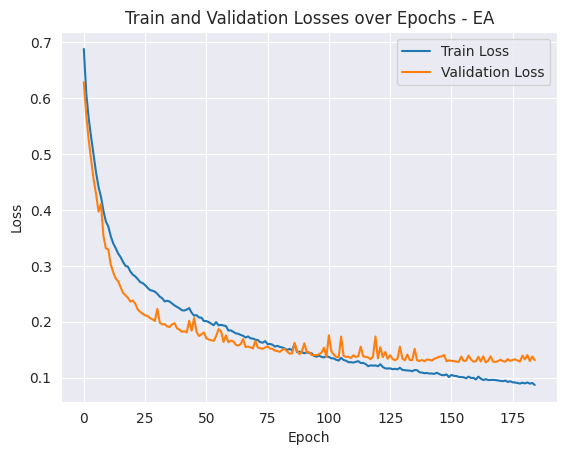

In [38]:
sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Train Loss")
plt.plot(list_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Losses over Epochs - EA")
plt.legend()
plt.show()

In [39]:
#OVERFIT Changes: Learning rate= 0.001 -> 0.01 , num_epochs 500-> 1000 & early_stop= 20 -> None
torch.manual_seed(190401038)  # Set the seed value to school student number

# Initialize the model and optimizer
model = MLP(input_dim=x_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

list_train_loss = []  
list_val_loss = []  

# Train the model
train(model, optimizer, criterion, train_loader, val_loader, num_epochs=2000,epoch_display=100)

Epoch 0, Train Loss: 0.5396, Validation Loss: 0.3534
Epoch 100, Train Loss: 0.0114, Validation Loss: 0.2229
Epoch 200, Train Loss: 0.0024, Validation Loss: 0.2794
Epoch 300, Train Loss: 0.0011, Validation Loss: 0.3037
Epoch 400, Train Loss: 0.0006, Validation Loss: 0.3299
Epoch 500, Train Loss: 0.0005, Validation Loss: 0.3391
Epoch 600, Train Loss: 0.0004, Validation Loss: 0.3534
Epoch 700, Train Loss: 0.0003, Validation Loss: 0.3600
Epoch 800, Train Loss: 0.0002, Validation Loss: 0.3745
Epoch 900, Train Loss: 0.0002, Validation Loss: 0.3764
Epoch 1000, Train Loss: 0.0002, Validation Loss: 0.3823
Epoch 1100, Train Loss: 0.0002, Validation Loss: 0.3874
Epoch 1200, Train Loss: 0.0001, Validation Loss: 0.3937
Epoch 1300, Train Loss: 0.0001, Validation Loss: 0.3987
Epoch 1400, Train Loss: 0.0001, Validation Loss: 0.4022
Epoch 1500, Train Loss: 0.0001, Validation Loss: 0.4074
Epoch 1600, Train Loss: 0.0001, Validation Loss: 0.4101
Epoch 1700, Train Loss: 0.0001, Validation Loss: 0.4138
Epoc

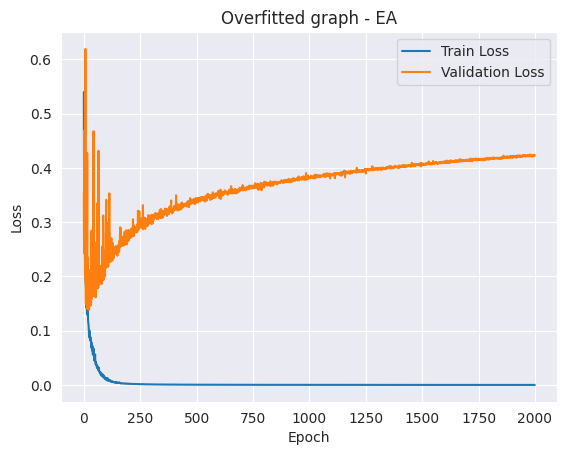

In [40]:
#Overfit Graph
sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Train Loss")
plt.plot(list_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Overfitted graph - EA")
plt.legend()
plt.show()

In [41]:
end = time.time()

#Check if Colab is running on the CPU or the GPU.
if tf.test.gpu_device_name():
    print("GPU Run time:", end - start)
else:
    print("CPU Run time:", end - start)

CPU Run time: 201.2263171672821
